# Illustrations of Phonlab library

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import librosa
import numpy as np

import seaborn as sns
import parselmouth
from IPython.display import Audio

cwd = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))

import phonlab as phon

import importlib
importlib.reload(phon)

print(phon.__name__,phon.__version__)
print(phon.get_timestamp_now())

phonlab 0.0.1
('2024-11-16T101829', '-0800')


In [2]:

x = np.zeros(100)
phon.smoothn(x)

AttributeError: module 'phonlab' has no attribute 'smoothn'

## phon.sgram()

Makes a pretty good looking spectrogram

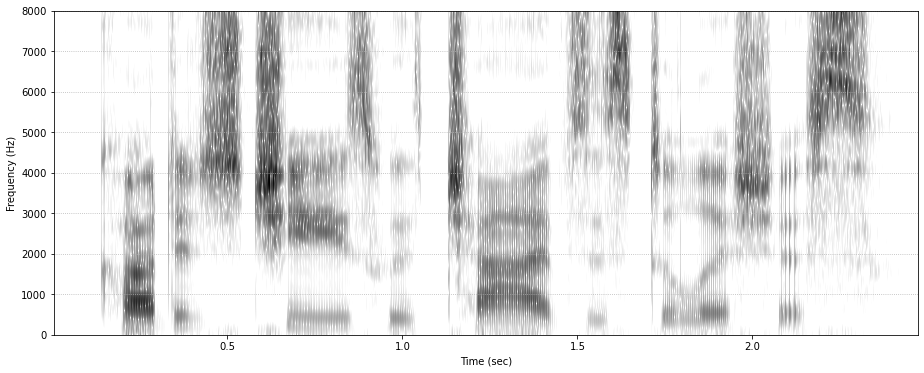

In [4]:
phon.sgram("sf3_cln.wav")
Audio("sf3_cln.wav")

## phon.track_formants()

Python native code implements both LPC and Inverse Filter Control (IFC) vowel formant tracking. 

IFC_tracking(), using method ifc, with speaker set to 1, and pitch range [63, 400]
 done         


,sec,rms,F1,F2,F3,F4,f0,voicing
0,0.01,13.6,648.0,2013.5,3143.1,4280.9,120.0,0.001169
1,0.02,16.3,1085.0,2189.2,3219.5,4235.2,160.0,0.000507
2,0.03,17.6,1210.6,2264.6,3296.5,4228.4,111.1,0.000465
3,0.04,15.3,717.6,1921.7,3283.6,4227.4,400.0,0.001458
4,0.05,12.6,590.8,1948.0,3352.0,4428.1,107.1,0.001979


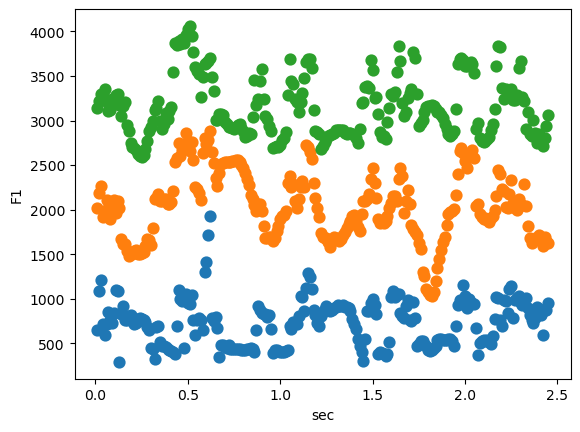

In [3]:
fmtsdf = phon.track_formants("sf3_cln.wav",method='ifc',speaker=1)

sns.pointplot(fmtsdf,x='sec',y='F1',linestyles='none', native_scale=True)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True)

fmtsdf.head()

### phon.formant2df

One of the **Tidypraat** routines working with parselmouth to call Praat functions in python

,sec,F1,F2,F3,F4
0,0.025906,1306.769820,2388.720107,3488.283346,4394.639375
1,0.032156,1443.269711,2406.732135,3513.311764,4443.028199
2,0.038406,1606.757851,2623.228265,3179.217973,4291.317958
3,0.044656,1740.477772,2081.097301,3339.921171,4417.462318
4,0.050906,1382.584341,2251.298675,3497.364026,4435.417474


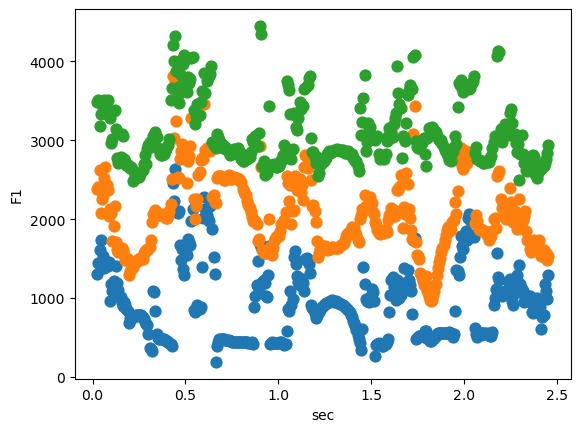

In [4]:
snd = parselmouth.Sound("sf3_cln.wav")  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmntdf = phon.formant2df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

sns.pointplot(fmntdf,x='sec',y='F1',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F2',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F3',linestyle='none',native_scale=True)

fmntdf.head()

Resampling from 16000 to 12000


,sec,f0,rms,c,probv,voiced
0,0.02,146.341463,0.000312,0.340571,0.022067,False
1,0.03,184.615385,0.000348,0.385508,0.034170,False
2,0.04,146.341463,0.000353,0.345541,0.023175,False
3,0.05,196.721311,0.000408,0.283095,0.012553,False
4,0.06,151.898734,0.000469,0.397357,0.038346,False


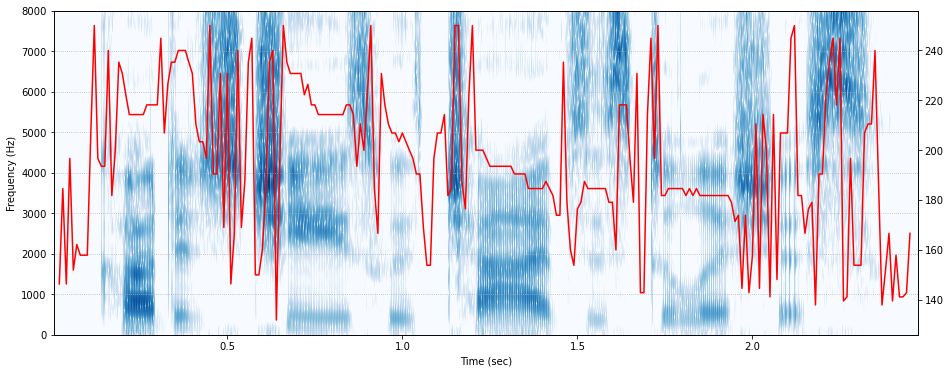

In [5]:
x,fs = phon.get_signal("sf3_cln.wav",pre= 0, fs=16000)  # note pre=0 is important here

f0df = phon.get_f0(x,fs_in=fs,pre=0.94, f0_range=[130,250])
#f0df.loc[f0df["probv"] < 0.05, ("f0")] = np.nan # ignore nonvocalic formants

ret = phon.sgram(x,fs_in = fs,cmap='Blues') # draw the spectrogram from the array of samples
ax1 = ret[0]  # the first item returned
ax2 = ax1.twinx()

ax2.plot(f0df.sec,f0df.f0, color = "red")  # add scaled diff function



f0df.head()

<Axes: xlabel='rms', ylabel='c'>

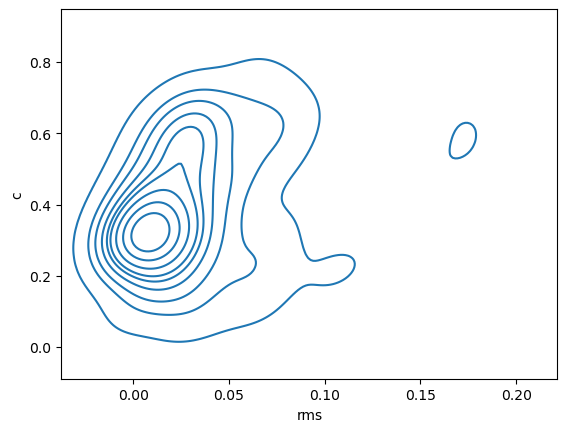

In [6]:
sns.kdeplot(f0df,x="rms",y="c")

## phon.amplitude_envelope()

Here's an intersting application of one of the phonab functions.  Get the amplitude envelope in a low frequency band, and then in a high frequency band.  The difference between them (plotted in red over the spectrogram below) segments the speech into consonant and vowel regions.  Above zero is 'vocalic' and below zero is 'consonantal'.

Resampling from 22050 to 16000


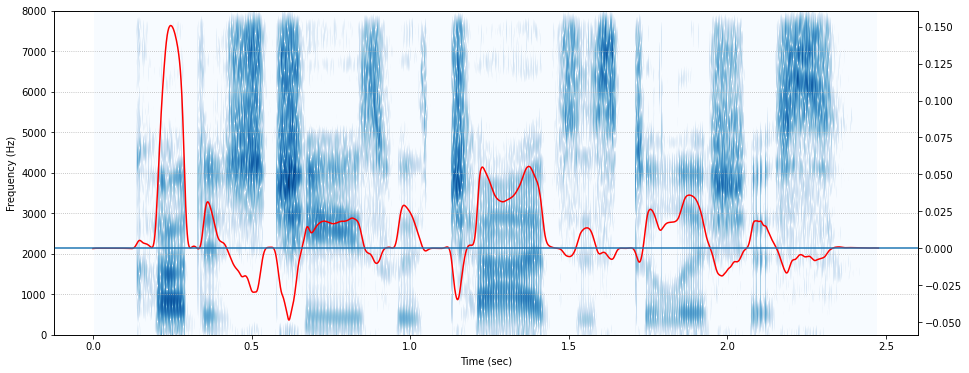

In [7]:
x,fs = phon.get_signal("sf3_cln.wav",pre= 0)  # note pre=0 is important here

lband, fs_diff = phon.amplitude_envelope(x,bounds=[120,3000],fs_in=fs, fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,bounds=[3000,5999],fs_in=fs,fs=12000)

diff = lband-hband  # the difference in the low and high envelopes
time_axis = np.arange(len(diff))/fs_diff  # a time axis for envelope plotting

ax1,f,t,Sxx = phon.sgram(x,fs_in = fs,cmap='Blues') # draw the spectrogram from the array of samples

ax2 = ax1.twinx()
ax2.plot(time_axis,diff, color = "red")  # add scaled diff function
ax2.axhline(0) 

Audio("sf3_cln.wav")

### Vocalic

This code block uses the diff[] array plotted above to define a **vocalic** feature, 
and then uses that feature to clean up the formant plot.  This is really only needed for 
nice looking graphs.  Illustrating here the three main formant tracking algorithms.

IFC_tracking(), using method ifc, with speaker set to 1, and pitch range [63, 400]
 done         


<Axes: xlabel='Time (sec)', ylabel='Frequency (Hz)'>

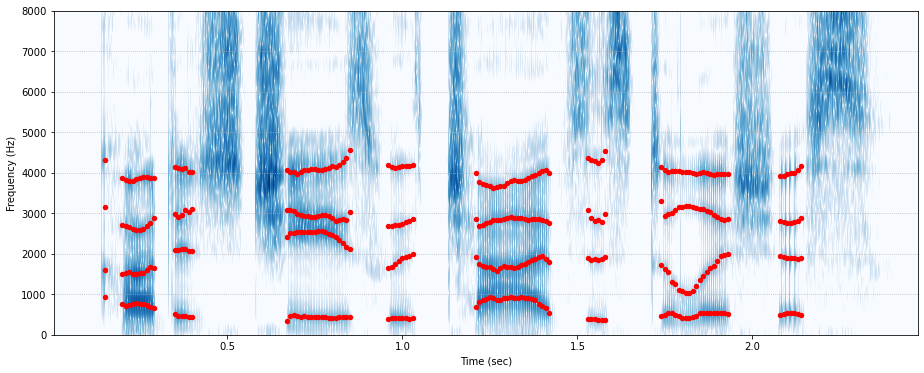

In [8]:
# 1) IFC formant tracking
fmtsdf = phon.track_formants("sf3_cln.wav",method='ifc',speaker=1)

# 2) Python native LPC formant tracking
#fmtsdf = phon.track_formants("sf3_cln.wav")

# 3) Praat LPC formant tracking
snd = parselmouth.Sound("sf3_cln.wav")  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
#fmtsdf = phon.formant2df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

# ------ use "vocalic" to decide which formant measurements to draw --------
x,fs = phon.get_signal("sf3_cln.wav",pre= 0)  # note pre=0 is important here
lband, fs_diff = phon.amplitude_envelope(x,bounds=[120,3000],fs_in=fs, fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,bounds=[3000,5999],fs_in=fs,fs=12000)
diff = lband-hband  # the difference in the low and high envelopes
fmtsdf["vocalic"] = diff[(fmtsdf['sec']*fs_diff).astype(int)]>0.005  # add 'vocalic' to the dataframe
fmtsdf.loc[fmtsdf["vocalic"] == False, ("F1","F2","F3","F4")] = np.nan # ignore nonvocalic formants

phon.sgram("sf3_cln.wav", cmap="Blues")  # plot the spectrogram

# add formant dots to the spectrogram
dot_color = "red"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

## phon.fricative()

Implements both major peak analysis and moments analysis.  The spectrum at time 0.635 (the 'ch' in 'cheese') illustrates that the "major peak" is the first well separated peak, not the point of maximum amplitude in the spectrum.

first major peak at 2950.0, Center of Gravity is 4765.6


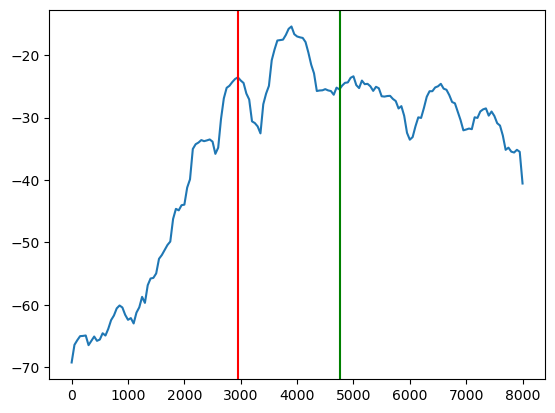

In [9]:
x,fs = phon.get_signal("sf3_cln.wav", pre=1,fs=None)

Fm,FmB,Am,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(x,0.635,fs)
print(f"first major peak at {Fm:.1f}, Center of Gravity is {COG:.1f}")
plt.plot(freq,spec)
plt.axvline(Fm,color="red")
plt.axvline(COG,color="green")

## phon.burst()

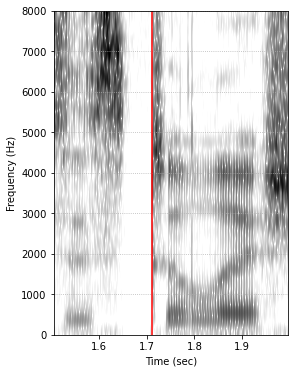

In [13]:
x,fs = phon.get_signal("sf3_cln.wav",pre=1)

t1 = 1.5
t2 = 2

b_time, b_score = phon.burst(x,t1,t2,fs)  # find a stop burst in the span from t1 to t2

 
ax1,f,t,Sxx = phon.sgram("sf3_cln.wav",start=t1, end=t2)
ax1.axvline(b_time,color="red")


### phon.egg2oq()

With a stereo audio file having audio in the left (channel 0) and electroglottography in the right (channel 1),
this function returns a time axis, f0, and open quotient.


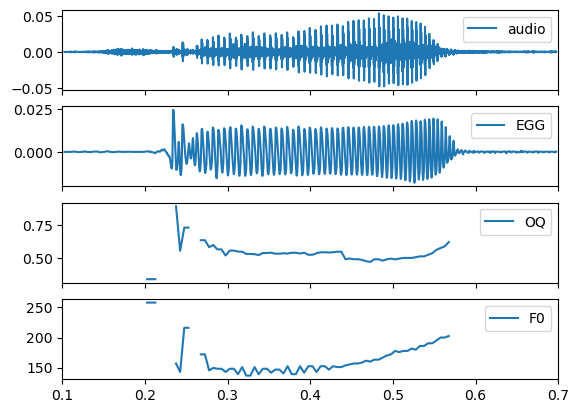

In [33]:
path = "F1_bha24_1.wav"  # a stereo file with audio in 0 and egg in 1

oqdf = phon.egg2oq(path,egg_channel=1)  # return open quotient data

# ------ The rest of this example is making a nice plot ---------
data, fs = librosa.load(path, mono=False)
audio = data[0]  # making an assumption here about channel assignments
egg = data[1]

time = [i/fs for i in range(audio.size)]  # the times of the audio samples.

start_time = 0.1
end_time = start_time + 0.6

sf = np.abs(oqdf.sec - start_time).argmin()  # closest frame to start_time
ef = np.abs(oqdf.sec - end_time).argmin()      # closest frame to end_time

si = int(oqdf.sec.iloc[sf]*fs)  # index of those frame times
ei = int(oqdf.sec.iloc[ef]*fs)    # in the audio and egg signals

fig = plt.figure()
ax1 =fig.add_subplot(411)
ax1.plot(time[si:ei],audio[si:ei],label="audio")
ax1.set_xlim(start_time,end_time)
ax1.set_xticklabels(([]))
ax1.legend()

ax2 =fig.add_subplot(412,sharex=ax1)
ax2.plot(time[si:ei],egg[si:ei],label="EGG")
ax2.legend()

ax3 =fig.add_subplot(413,sharex=ax1)
ax3.plot(oqdf.sec.iloc[sf:ef],oqdf.OQ.iloc[sf:ef],label="OQ")
ax3.legend()

ax4 =fig.add_subplot(414)
ax4.plot(oqdf.sec.iloc[sf:ef],oqdf.f0.iloc[sf:ef],label="F0")
ax4.set_xlim(start_time,end_time)
ax4.legend()


## phon.sine_synth()

With a formants data frame from phon.track_formants(), sine_synth() produces sine wave analogs of speech.

LPC_tracking(), with order set to -1, and pitch range [63, 400]
Selected LPC order is: 10


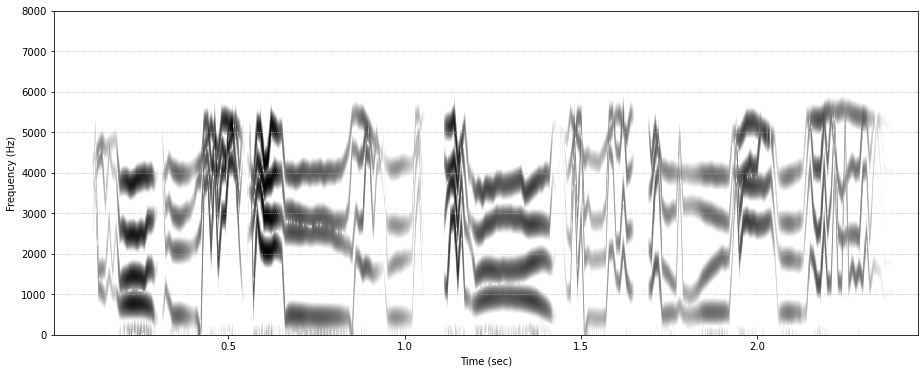

In [15]:
x,fs = librosa.load("sf3_cln.wav",sr=12000)   # illustrating here that we can pass an array to track_formants()
fmtsdf = phon.track_formants(x,fs_in = fs)    # track the formants

x2,fs2 = phon.sine_synth(fmtsdf)     # use the formants to produce sinewave synthesis
phon.sgram(x2,fs_in=fs2, preemph=0)  # plot a spectrogram of it

Audio(x2,rate=fs2) 

## phon.sigcor_noise()

Replace signal with noise that matches the amplitude envelope of the signal

Resampling from 22050 to 16000


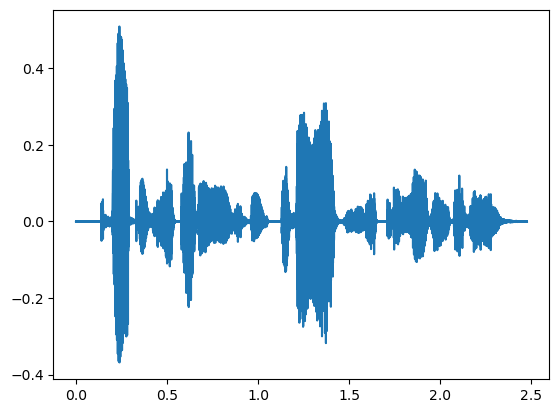

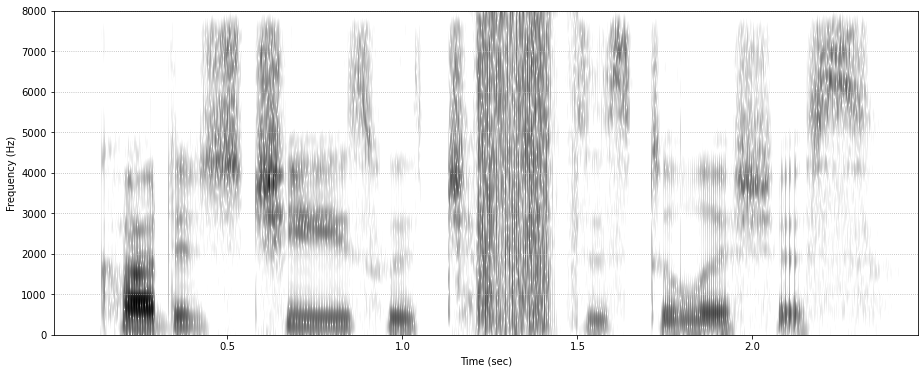

In [16]:
x,fs = phon.sigcor_noise("sf3_cln.wav",flip_rate=0.4,start=1.2,end=1.5)

time_axis = np.arange(len(x))/fs
plt.plot(time_axis,x)  # add_noise pads the signal by 0.5 seconds

phon.sgram(x,fs_in=fs,preemph=0)
Audio(x,rate=fs) 

## phon.add_noise()

A function that can be used to prepare speech in noise (SPIN) stimuli.


Resampling from 22050 to 16000


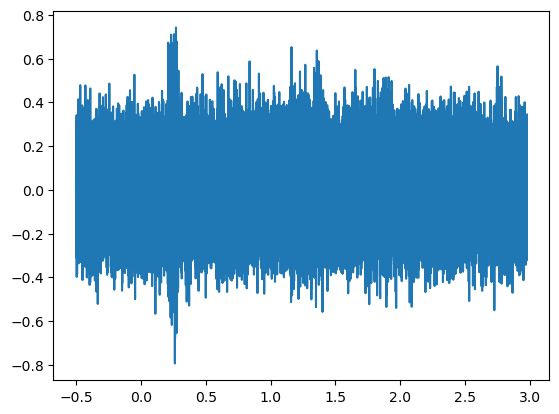

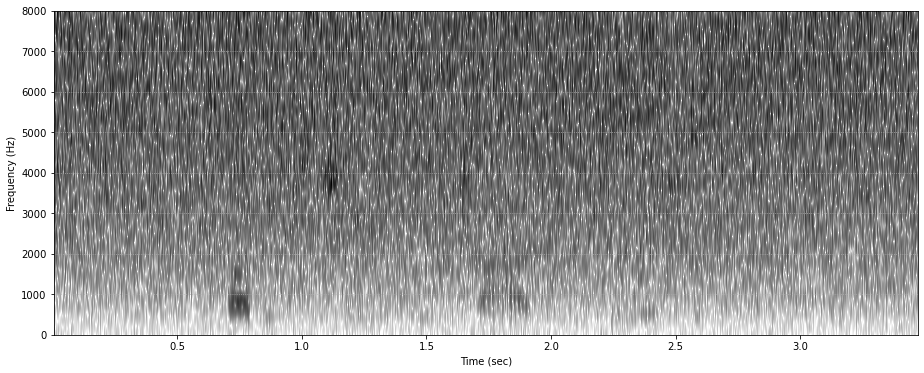

In [17]:
x,fs = phon.add_noise("sf3_cln.wav","white",snr=3)
time_axis = np.arange(len(x))/fs

plt.plot(time_axis - 0.5,x)  # add_noise pads the signal by 0.5 seconds
phon.sgram(x,fs_in=fs)
Audio(x,rate=fs) 

## phon.vocode()

Resynthesize speech with noise in frequency bands, simulating the amount of audio information in a cochlear implant.

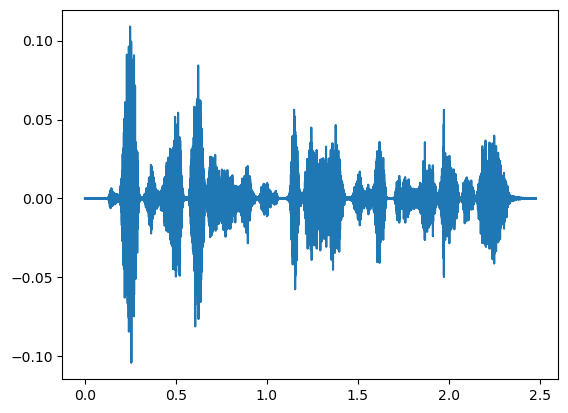

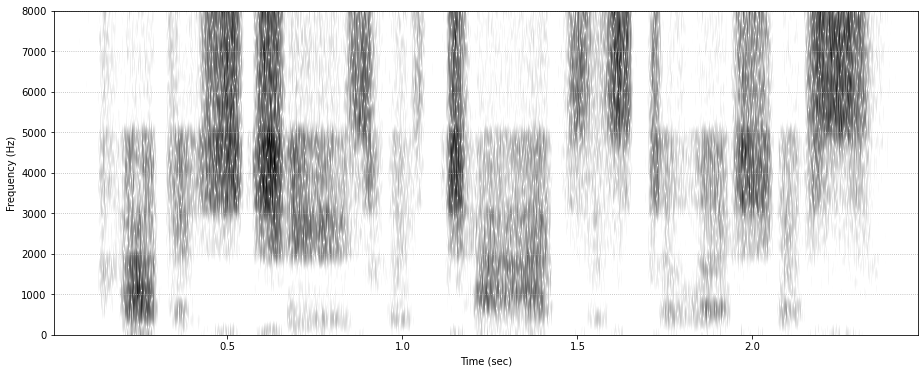

In [25]:
bands_third = phon.third_octave_bands(high=8000)  # define filter bank
bands_shan = phon.shannon_bands(high=8000,nc=10)  # define filter bank

y,fs = phon.vocode("sf3_cln.wav", bands_shan, fs=16000)  # use one of the filter banks

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)

phon.sgram(y,fs_in=fs)

Audio(y,rate=fs) 